<a href="https://colab.research.google.com/github/the-chosen-wan/deepfake-detection/blob/main/vit_patchwise_soft_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import cv2
import os
import glob

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, self.patch_size, self.patch_size, 3])
        return patches

In [ ]:
class inverse_patch(layers.Layer):
  def __init__(self,target_shape,patch_size):
    super(inverse_patch,self).__init__()
    self.H = target_shape[0]
    self.B = target_shape[1]
    self.C = target_shape[2]
    self.patch_size = patch_size

  def get_config(self):
    config = super(inverse_patch,self).get_config()
    config['patch_size']=self.patch_size
    return config
  
  def call(self,x):
    batch_size = tf.shape(x)[0]
    num_patches = tf.shape(x)[1]
    pad = [[0,0],[0,0]]
    p = self.patch_size
    h = self.H
    patches = tf.reshape(x,[batch_size,num_patches,p,p,self.C])
    patches_proc = tf.reshape(patches,[batch_size,h//p,h//p,p*p,self.C])
    patches_proc = tf.split(patches_proc,p*p,3)
    patches_proc = tf.stack(patches_proc,axis=0)
    patches_proc = tf.reshape(patches_proc,[p*p*batch_size,h//p,h//p,self.C])
    reconstructed = tf.compat.v1.batch_to_space_nd(patches_proc,[p, p],pad)
    return reconstructed

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [ ]:
class Transformer(layers.Layer):
    def __init__(self, projection_dim, transformer_units):
      super(Transformer, self).__init__()
      self.projection_dim = projection_dim
      self.transformer_units = transformer_units

    def build(self, input_shape):
      self.LayerNormalization = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.attention = tf.keras.layers.MultiHeadAttention(num_heads=1, key_dim=self.projection_dim, dropout=0.1)
      self.Add = tf.keras.layers.Add()
      self.Dense1 = tf.keras.layers.Dense(self.transformer_units[0], activation=tf.nn.gelu)
      self.Dense2 = tf.keras.layers.Dense(self.transformer_units[1], activation=tf.nn.gelu)
      self.Dropout = tf.keras.layers.Dropout(0.1)

    def call(self, encoded_patch):

      x1 = self.LayerNormalization(encoded_patch)
      attention_output = self.attention(x1, x1)
      x2 = self.Add([attention_output, encoded_patch])
      x3 = self.LayerNormalization(x2)
      x3 = self.Dense1(x3)
      x3 = self.Dropout(x3)
      x3 = self.Dense2(x3)
      x3 = self.Dropout(x3)

      encoded_patches = self.Add([x3, x2])
      return encoded_patches

In [ ]:
class SoftAttention(layers.Layer):
  def __init__(self, patch_size):
    super(SoftAttention, self).__init__()
    self.patch_size = patch_size

  def build(self, input_shape):
    self.H = input_shape[1]
    self.conv=[]
    for i in range((self.H//self.patch_size)**2):
      self.conv.append(layers.Conv2D(filters=3,kernel_size=3,padding='same',kernel_initializer='he_normal',bias_initializer='ones'))
    self.Multiply = tf.keras.layers.Multiply()
    self.flatten = layers.Flatten()

  def call(self, image_batch):
    image_attention = []

    for i in range(0 ,256 , self.patch_size):
      for j in range(0 ,256 , self.patch_size):
          patch = image_batch[ : , i : i + self.patch_size , j : j + self.patch_size , : ]
          patch_conved = self.conv[(self.H//self.patch_size)*(i//self.patch_size)+(j//self.patch_size)](patch)
          out = self.Multiply([patch, patch_conved])
          image_attention.append(self.flatten(out))

    image_attention = tf.convert_to_tensor(image_attention)
    image_attention = tf.transpose(image_attention,perm=[1,0,2]) 

    return image_attention

In [ ]:
vit  = tf.keras.models.load_model('/content/drive/My Drive/saved/pretrained_vit_B_16_256')

In [ ]:
def get_model( patch_size):
  inp = tf.keras.layers.Input(shape=(256, 256, 3))
  #x = layers.BatchNormalization()(inp)
  soft_patch = SoftAttention(patch_size)(inp)
  soft_patch = inverse_patch((256,256,3),patch_size)(soft_patch)
  #soft_patch = tf.reshape(soft_patch, (-1, soft_patch.get_shape()[1],soft_patch.get_shape()[2]*soft_patch.get_shape()[3]*soft_patch.get_shape()[4]))

  transformed = vit(soft_patch)

  flatten = tf.keras.layers.Flatten()(transformed)
  #dropout = tf.keras.layers.Dropout(0.5)(flatten)
  dense = tf.keras.layers.Dense(4096, activation='relu')(flatten)
  dense = tf.keras.layers.Dropout(0.5)(dense)
  dense = tf.keras.layers.Dense(1024, activation='relu')(dense)
  dense = tf.keras.layers.Dropout(0.5)(dense)
  dense = tf.keras.layers.Dense(512, activation='relu')(dense)
  dense = tf.keras.layers.Dropout(0.5)(dense)
  dense = tf.keras.layers.Dense(2, activation='softmax')(dense)
    
  return tf.keras.Model(inputs=inp, outputs=dense)

In [ ]:
def get_model( patch_size):
  inp = tf.keras.layers.Input(shape=(256, 256, 3))
  #x = layers.BatchNormalization()(inp)
  soft_patch = SoftAttention(patch_size)(inp)
  soft_patch = inverse_patch((256,256,3),patch_size)(soft_patch)
  #soft_patch = tf.reshape(soft_patch, (-1, soft_patch.get_shape()[1],soft_patch.get_shape()[2]*soft_patch.get_shape()[3]*soft_patch.get_shape()[4]))

  transformed = vit(soft_patch)

  flatten = tf.keras.layers.Flatten()(transformed)
  #dropout = tf.keras.layers.Dropout(0.5)(flatten)
  dense = tf.keras.layers.Dense(4096, activation='relu')(flatten)
  dense = tf.keras.layers.Dropout(0.5)(dense)
  dense = tf.keras.layers.Dense(1024, activation='relu')(dense)
  dense = tf.keras.layers.Dropout(0.5)(dense)
  dense = tf.keras.layers.Dense(512, activation='relu')(dense)
  dense = tf.keras.layers.Dropout(0.5)(dense)
  dense = tf.keras.layers.Dense(2, activation='softmax')(dense)
    
  return tf.keras.Model(inputs=inp, outputs=dense)

In [ ]:
final_model= get_model(16)
#final_model = tf.keras.models.load_model('/content/drive/My Drive/saved/patch_wise_simple_attention')

In [ ]:
final_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 soft_attention_4 (SoftAtten  (None, 256, 768)         21504     
 tion)                                                           
                                                                 
 inverse_patch_3 (inverse_pa  (None, 256, 256, 3)      0         
 tch)                                                            
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten_3 (Flatten)         (None, 768)               0         
                                                                 
 dense_9 (Dense)             (None, 4096)              3149

*DATA PIPELINE*

In [ ]:
#GETS TRAIN FILES PATH
train_files = []
label_files= ['fake','real']
for x in os.walk('/content/drive/My Drive/data_fakesecond/train'):
    for y in glob.glob(os.path.join(x[0], '*.jpg')):
        train_files.append(y)
print(len(train_files))

15958


In [ ]:
#GETS VAL FILES PATH
val_files = []
label_files= ['real','fake']
for x in os.walk('/content/drive/My Drive/celeb/test'):
    for y in glob.glob(os.path.join(x[0], '*.jpg')):
        val_files.append(y)
print(len(val_files))

518


In [ ]:
import cv2
#GETS IMAGE ARRAY OUT GIVEN AN IMAGE PATH
def get_input(path):
    im = cv2.imread(path)
    return(im)
 
#CREATES LABEL VECTORE [0,1] OR [1,0] BY EXPLOITING CLASS TYPE label_files IN FILE PATH 
def get_output( path, label_files,mode):
    if mode =='train':
      img_id = path.split('/')[-2]
    else:
      img_id = path.split('/')[-1].split('_')[0].lower()
    laba = []
    for label in label_files:
      if label == img_id:
        laba.append(1)
      else:
        laba.append(0)
    return laba

In [ ]:
#GENERATOR FUNCTION TO PASS THE IMAGES AND LABELS TO model.fit FOR TRAINING
def image_generator_test(files, label_files,mode, resize=(256,256)):
 
  batch_x = []
  batch_y = [] 
          
  for input_path in files:
      input = get_input(input_path)
      output = get_output(input_path, label_files,mode)
      if resize is not None:
        input = cv2.resize(input, resize)
        #input  = input[np.newaxis,:,:,:]
        batch_x.append(input)
        batch_y.append(output)
   
  batch_x = tf.convert_to_tensor(batch_x)
  batch_x = tf.cast(batch_x,dtype='float32')
  #batch_x = tf.keras.applications.xception.preprocess_input(batch_x)
  #batch_x = batch_x / 255.0
  batch_y = tf.convert_to_tensor(batch_y)
  #batch_x = patch_encoder(batch_x)

  return batch_x, batch_y

imx,imy = image_generator_test(val_files,label_files,'val')

In [ ]:
#GENERATOR FUNCTION TO PASS THE IMAGES AND LABELS TO model.fit FOR TRAINING
def image_generator(files, label_files, batch_size,mode, resize=(256,256)):
 
      while True:
          batch_paths  = np.random.choice(a  = files, 
                                          size = batch_size)
          batch_x = []
          batch_y = [] 
          
          for input_path in batch_paths:
              input = get_input(input_path)
              output = get_output(input_path, label_files,mode)
              if resize is not None:
                input = cv2.resize(input, resize)
              #input  = input[np.newaxis,:,:,:]
              batch_x.append(input)
              batch_y.append(output)
   
          batch_x = tf.convert_to_tensor(batch_x)
          batch_x = tf.cast(batch_x,dtype='float32')
          #batch_x = tf.keras.applications.xception.preprocess_input(batch_x)
          #batch_x = batch_x / 255.0
          batch_y = tf.convert_to_tensor(batch_y)
          #batch_x = patch_encoder(batch_x)

          yield batch_x, batch_y

In [ ]:
#TRAINING
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
final_model.compile(opt, loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy',tf.keras.metrics.AUC(name='auc')])
 
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=False, monitor='val_auc', mode='max')

final_model.fit(image_generator(train_files, label_files, batch_size = 16, mode='train'), epochs = 100, steps_per_epoch = 40,validation_data=(imx,imy),validation_batch_size=1,callbacks=[model_checkpoint_callback])

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.7894 - accuracy: 0.4891 - auc: 0.4966

INFO:tensorflow:Assets written to: /content/checkpoint/assets


INFO:tensorflow:Assets written to: /content/checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


40/40 [==============================] - 523s 12s/step - loss: 0.7894 - accuracy: 0.4891 - auc: 0.4966 - val_loss: 0.6526 - val_accuracy: 0.6564 - val_auc: 0.6629
Epoch 2/100
40/40 [==============================] - 392s 10s/step - loss: 0.7460 - accuracy: 0.5281 - auc: 0.5343 - val_loss: 0.7008 - val_accuracy: 0.3475 - val_auc: 0.3552
Epoch 3/100
40/40 [==============================] - 383s 10s/step - loss: 0.7500 - accuracy: 0.5047 - auc: 0.4983 - val_loss: 0.7216 - val_accuracy: 0.3436 - val_auc: 0.3883
Epoch 4/100
40/40 [==============================] - 372s 10s/step - loss: 0.7440 - accuracy: 0.4859 - auc: 0.4785 - val_loss: 0.6997 - val_accuracy: 0.3475 - val_auc: 0.3491
Epoch 5/100
40/40 [==============================] - 362s 9s/step - loss: 0.7335 - accuracy: 0.4656 - auc: 0.4674 - val_loss: 0.6932 - val_accuracy: 0.5174 - val_auc: 0.4897
Epoch 6/100
40/40 [==============================] - 336s 9s/step - loss: 0.7133 - accuracy: 0.5172 - auc: 0.5096 - val_loss: 0.6545 - val

INFO:tensorflow:Assets written to: /content/checkpoint/assets


INFO:tensorflow:Assets written to: /content/checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


40/40 [==============================] - 421s 11s/step - loss: 0.7174 - accuracy: 0.4875 - auc: 0.4938 - val_loss: 0.6848 - val_accuracy: 0.6564 - val_auc: 0.6650
Epoch 9/100
40/40 [==============================] - ETA: 0s - loss: 0.7128 - accuracy: 0.4938 - auc: 0.5002

INFO:tensorflow:Assets written to: /content/checkpoint/assets


INFO:tensorflow:Assets written to: /content/checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


40/40 [==============================] - 397s 10s/step - loss: 0.7128 - accuracy: 0.4938 - auc: 0.5002 - val_loss: 0.6758 - val_accuracy: 0.6564 - val_auc: 0.6677
Epoch 10/100
14/40 [=========>....................] - ETA: 2:46 - loss: 0.7085 - accuracy: 0.4955 - auc: 0.5096

In [ ]:
drive.mount('/content/gdrive')
final_model.save('/content/gdrive/My Drive/saved/patch_wise_simple_attention')

NameError: ignored

In [ ]:
ppp = mod.predict(im)

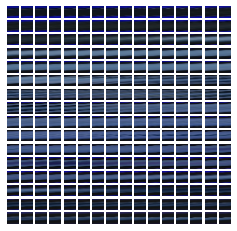

In [ ]:
import matplotlib.pyplot as plt

n = int(np.sqrt(ppp.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(ppp[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (16, 16, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
#TRAINING
mod.compile(tf.keras.optimizers.Adam(lr = 0.001), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])
 
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

mod.fit(image_generator(train_files, train_label_files, batch_size = 32, mode='train'), epochs = 100, steps_per_epoch = 40, validation_data = image_generator(val_files, val_label_files, batch_size = 32, mode='train'), validation_steps = 15, callbacks=[model_checkpoint_callback])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5141

INFO:tensorflow:Assets written to: /content/checkpoint/assets


INFO:tensorflow:Assets written to: /content/checkpoint/assets


40/40 [==============================] - 24s 528ms/step - loss: 0.6930 - accuracy: 0.5141 - val_loss: 0.6935 - val_accuracy: 0.4979
Epoch 2/100


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


40/40 [==============================] - 13s 319ms/step - loss: 0.6936 - accuracy: 0.4922 - val_loss: 0.6931 - val_accuracy: 0.4771
Epoch 3/100
40/40 [==============================] - 13s 319ms/step - loss: 0.6936 - accuracy: 0.4844 - val_loss: 0.6936 - val_accuracy: 0.4812
Epoch 4/100
40/40 [==============================] - 12s 316ms/step - loss: 0.6937 - accuracy: 0.4867 - val_loss: 0.6935 - val_accuracy: 0.4771
Epoch 5/100
40/40 [==============================] - 12s 317ms/step - loss: 0.6934 - accuracy: 0.4695 - val_loss: 0.6931 - val_accuracy: 0.4958
Epoch 6/100
40/40 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5016

KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf
mod = tf.keras.models.load_model('/content/drive/MyDrive/mesoinceptv1_FF++/mesoinceptv1_FF++')

In [ ]:
mod.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 4)  16          ['input_1[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 256, 256, 4)  16          ['input_1[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 256, 256, 2)  8           ['input_1[0][0]']            